The purpose of this update is to subject the data to apply spatial estimation analysis to assess the spatial uncertainties over our study area, given the available data and the models of spatial continuity previously built. 
The work included:

Calculating the probability of each facies across the reservoir

Computing the Kriging estimate and variance for porosity and permeability over the entire prospect, for each facies

Building a combined model (cookie cutter approach) with porosity and permeability for the most likely facies at all locations

Picking two candidate well locations and provide a pre-drill porosity uncertainty distribution accounting for the probability of each facies

# 1. Import packages and load dataset



In [21]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python      
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import random
import math
import scipy.signal as signal  

In [2]:
df = pd.read_csv('8_sample_data.csv')     # load our data table

Plotting parameters

In [3]:
pormin = 0.05; pormax = 0.25
permmin = 0.01; permmax = 1000;                # user specified min and max
AImin = 1000.0; AImax = 6000
Fmin = 0; Fmax = 1

xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25
permmin = 0.01; permmax = 300;                # user specified min and max
AImin = 1000.0; AImax = 6000
Fmin = 0; Fmax = 1
cmap = plt.cm.plasma                    # color map

In [40]:
nx = 100; ny = 100; csize = 10.0
xsiz = 10; ysiz = 10
xmn = 5; ymn = 5

In [8]:
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,168.000000,168.000000,168.00000,168.000000,168.000000,168.000000,168.000000
mean,207.767857,514.345238,465.87500,0.666667,0.153916,77.403572,3396.279944
std,114.277788,290.006483,286.99991,0.472814,0.034007,202.949762,748.991891
min,3.000000,0.000000,20.00000,0.000000,0.080884,0.046707,1189.857907
25%,104.000000,260.000000,209.00000,0.000000,0.130374,2.889615,2923.281779
50%,216.500000,490.000000,439.50000,1.000000,0.150119,12.088688,3456.145034
75%,306.750000,780.000000,729.00000,1.000000,0.177243,65.522793,3957.836990
max,381.000000,990.000000,979.00000,1.000000,0.249454,2056.729133,5186.291314


In [4]:
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records

In [45]:
df_sand.describe()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,112.000000,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000
mean,81.035714,201.937500,516.428571,408.142857,1.0,0.165880,110.068496,3109.814779
std,48.390106,113.631955,276.984590,278.284832,0.0,0.032048,241.522616,693.915972
min,1.000000,5.000000,0.000000,20.000000,1.0,0.083737,0.156970,1189.857907
25%,40.750000,102.000000,297.500000,160.000000,1.0,0.143944,4.987704,2584.387646
50%,76.500000,198.000000,490.000000,369.500000,1.0,0.166589,27.870215,3223.929842
75%,124.500000,305.250000,770.000000,634.250000,1.0,0.186953,114.014701,3597.645230
max,167.000000,381.000000,980.000000,979.000000,1.0,0.249454,2056.729133,4536.067943


In [46]:
df_shale.describe()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,56.000000,56.000000
mean,88.428571,219.428571,510.178571,581.339286,0.0,0.129989,12.073724,3969.210274
std,49.205268,115.698960,317.028769,271.012061,0.0,0.023757,28.605079,479.840085
min,0.000000,3.000000,60.000000,20.000000,0.0,0.080884,0.046707,2851.868733
25%,42.500000,107.000000,180.000000,439.750000,0.0,0.114131,0.424355,3681.067809
50%,97.000000,247.000000,500.000000,650.000000,0.0,0.128121,3.894984,3957.468966
75%,125.500000,308.500000,840.000000,781.500000,0.0,0.142070,9.739336,4261.175382
max,166.000000,380.000000,990.000000,979.000000,0.0,0.202176,188.228096,5186.291314


# 2. Indicator kriging

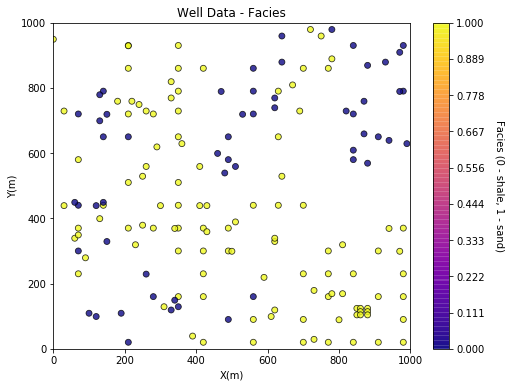

In [5]:
GSLIB.locmap(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap,'locmap_facies')

Declare functions

In [6]:
def setup_rotmat(c0, nst, it, cc, ang, pmx):

    PI = 3.141_592_65
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def ksol_numpy(neq, a, r):
    a = a[0: neq * neq]  # trim the array
    a = np.reshape(a, (neq, neq))  # reshape to 2D
    ainv = linalg.inv(a)  # invert matrix
    r = r[0: neq]  # trim the array
    s = np.matmul(ainv, r)  # matrix multiplication
    return s

def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    EPSLON = 0.000_000
    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1
    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
#        print('cova h'); print(h)
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

In [7]:
import scipy.spatial as sp         # for fast nearest nearbour search
import math  # for trig functions etc.
import numpy.linalg as linalg  # for linear algebra

def correct_trend(trend):
    ny = trend.shape[0]
    nx = trend.shape[1]
    ncut = trend.shape[2]
    for iy in range(0,ny):
        for ix in range(0,nx):
            sum = 0.0
            for ic in range(0,ncut):
                sum = sum + trend[iy,ix,ic]
            if sum > 0.0:
                for icut in range(0,ncut):
                    trend[iy,ix,ic] = trend[iy,ix,ic] / sum
    return trend

def ordrel(ivtype,ncut,ccdf):
#    print('input ordering relations'); print(ccdf)
    ccdfo = np.zeros(ncut)
    ccdf1 = np.zeros(ncut)
    ccdf2 = np.zeros(ncut) # do we need MAXCUT = 100 for these 2?

# Make sure conditional cdf is within [0,1]:
    for i in range(0,ncut):
        if ccdf[i] < 0.0:
            ccdf1[i] = 0.0
            ccdf2[i] = 0.0
        elif ccdf[i] > 1.0:
            ccdf1[i] = 1.0
            ccdf2[i] = 1.0
        else:
            ccdf1[i] = ccdf[i]
            ccdf2[i] = ccdf[i]
#    print('ordering relations'); print(ccdf1,ccdf2)

# Correct sequentially up, then down, and then average:
    if ivtype == 0:
        sumcdf = 0.0
        for i in range(0,ncut):
            sumcdf = sumcdf + ccdf1[i]
        if sumcdf <= 0.0: sumcdf = 1.0
        for i in range(0,ncut):
            ccdfo[i] = ccdf1[i] / sumcdf
    else:
        for i in range(1,ncut):
            if ccdf1[i] < ccdf1[i-1]: ccdf1[i] = ccdf1[i-1]
        for i in range(ncut-2,0,-1):
            if ccdf2[i] > ccdf2[i+1]: ccdf2[i] = ccdf2[i+1]
        for i in range(0,ncut):
            ccdfo[i] = 0.5*(ccdf1[i]+ccdf2[i])

# Return with corrected CDF:
    return ccdfo


def ik2d(df,xcol,ycol,vcol,ivtype,koption,ncut,thresh,gcdf,trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario): 

# Find the needed paramters:
    PMX = 9999.9
    MAXSAM = ndmax + 1
    MAXEQ = MAXSAM + 1
    mik = 0  # full indicator kriging
    use_trend = False
    if trend.shape[0] == nx and trend.shape[1] == ny and trend.shape[2] == ncut: use_trend = True
    
# load the variogram
    MAXNST = 2
    nst = np.zeros(ncut,dtype=int); c0 = np.zeros(ncut); cc = np.zeros((MAXNST,ncut)) 
    aa = np.zeros((MAXNST,ncut),dtype=int); it = np.zeros((MAXNST,ncut),dtype=int) 
    ang = np.zeros((MAXNST,ncut)); anis = np.zeros((MAXNST,ncut))

    for icut in range(0,ncut):
        nst[icut] = int(vario[icut]['nst'])
        c0[icut] = vario[icut]['nug']; cc[0,icut] = vario[icut]['cc1']; it[0,icut] = vario[icut]['it1']; 
        ang[0,icut] = vario[icut]['azi1']; 
        aa[0,icut] = vario[icut]['hmaj1']; anis[0,icut] = vario[icut]['hmin1']/vario[icut]['hmaj1'];
        if nst[icut] == 2:
            cc[1,icut] = vario[icut]['cc2']; it[1,icut] = vario[icut]['it2']; ang[1,icut] = vario[icut]['azi2']; 
            aa[1,icut] = vario[icut]['hmaj2']; anis[1,icut] = vario[icut]['hmin2']/vario[icut]['hmaj2'];

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    MAXDAT = len(df_extract)
    MAXCUT = ncut
    MAXNST = 2
    MAXROT = MAXNST*MAXCUT+ 1
    ikout = np.zeros((nx,ny,ncut))
    maxcov = np.zeros(ncut)
            
    # Allocate the needed memory:   
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXEQ)
    rr = np.zeros(MAXEQ)
    s = np.zeros(MAXEQ)
    a = np.zeros(MAXEQ*MAXEQ)
    ikmap = np.zeros((nx,ny,ncut))
    vr = np.zeros((MAXDAT,MAXCUT+1))
    
    nviol = np.zeros(MAXCUT)
    aviol = np.zeros(MAXCUT)
    xviol = np.zeros(MAXCUT)
    
    ccdf = np.zeros(ncut)
    ccdfo = np.zeros(ncut)
    ikout = np.zeros((nx,ny,ncut))
    
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    v = df_extract[vcol].values
    
# The indicator data are constructed knowing the thresholds and the
# data value.
    
    if ivtype == 0:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where((v <= thresh[icut] + 0.5) & (v > thresh[icut] - 0.5), '1', '0')
    else:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where(v <= thresh[icut], '1', '0')
    vr[:,ncut] = v

# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,MAXDAT))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
# Summary statistics of the input data
    
    avg = vr[:,ncut].mean()
    stdev = vr[:,ncut].std()
    ss = stdev**2.0
    vrmin = vr[:,ncut].min()
    vrmax = vr[:,ncut].max()
    print('Data for IK3D: Variable column ' + str(vcol))
    print('  Number   = ' + str(MAXDAT))
    ndh = MAXDAT
    
    actloc = np.zeros(MAXDAT, dtype = int)
    for i in range(1,MAXDAT):
        actloc[i] = i
    
# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search:

    print('Setting up rotation matrices for variogram and search')
    radsqd = radius * radius
    rotmat = []
    for ic in range(0,ncut):  
        rotmat_temp, maxcov[ic] = setup_rotmat(c0[ic],int(nst[ic]),it[:,ic],cc[:,ic],ang[:,ic],9999.9)
        rotmat.append(rotmat_temp)    
# Initialize accumulators:  # not setup yet
    nk = 0
    xk = 0.0
    vk = 0.0
    for icut in range (0,ncut):
        nviol[icut] =  0
        aviol[icut] =  0.0
        xviol[icut] = -1.0
    nxy   = nx*ny
    print('Working on the kriging')

# Report on progress from time to time:
    if koption == 0: 
        nxy   = nx*ny
        nloop = nxy
        irepo = max(1,min((nxy/10),10000))
    else:
        nloop = 10000000
        irepo = max(1,min((nd/10),10000))
    ddh = 0.0
    
# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    for index in range(0,nloop):
      
        if (int(index/irepo)*irepo) == index: print('   currently on estimate ' + str(index))
    
        if koption == 0:
            iy   = int((index)/nx) 
            ix   = index - (iy)*nx
            xloc = xmn + (ix)*xsiz
            yloc = ymn + (iy)*ysiz
        else:
            ddh = 0.0
            # TODO: pass the cross validation value

# Find the nearest samples within each octant: First initialize the counter arrays:
        na = -1   # accounting for 0 as first index
        dist.fill(1.0e+20)
        nums.fill(-1)
        current_node = (yloc,xloc)
        dist, close = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
        # remove any data outside search radius
        close = close[dist<radius]
        dist = dist[dist<radius] 
        nclose = len(dist) 

# Is there enough samples?

        if nclose < ndmin:   # accounting for min index of 0
            for i in range(0,ncut):
                ccdfo[i] = UNEST
            print('UNEST at ' + str(ix) + ',' + str(iy))
        else:         

# Loop over all the thresholds/categories:
            for ic in range(0,ncut):
                krig = True
                if mik == 1 and ic >= 1: krig = False

# Identify the close data (there may be a different number of data at
# each threshold because of constraint intervals); however, if
# there are no constraint intervals then this step can be avoided.
                nca = -1
                for ia in range(0,nclose):
                    j  = int(close[ia]+0.5)
                    ii = actloc[j]
                    accept = True
                    if koption != 0 and (abs(x[j]-xloc) + abs(y[j]-yloc)).lt.EPSLON: accept = False
                    if accept:
                        nca = nca + 1
                        vra[nca] = vr[ii,ic]
                        xa[nca]  = x[j]
                        ya[nca]  = y[j]

# If there are no samples at this threshold then use the global cdf:
                if nca == -1:
                    if use_trend:
                        ccdf[ic] = trend[ny-iy-1,ix,ic]
                    else:
                        ccdf[ic] = gcdf[ic]
                else:
            
# Now, only load the variogram, build the matrix,... if kriging:
                    neq = nclose + ktype
                    na = nclose

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na):
# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na):  # was j - want full matrix                    
                            iin = iin + 1
                            a[iin] = cova2(xa[i],ya[i],xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
                        if ktype == 1:
                            iin = iin + 1
                            a[iin] = maxcov[ic]            
                        r[j] = cova2(xloc,yloc,xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
    
# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na):
                            iin = iin + 1
                            a[iin] = maxcov[ic]
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq-1]  = maxcov[ic]
                        rr[neq-1] = r[neq]
# Solve the system:
                    if neq == 1:
                        ising = 0.0
                        s[0]  = r[0] / a[0]
                    else:
                        s = ksol_numpy(neq,a,r)

# Finished kriging (if it was necessary):

# Compute Kriged estimate of cumulative probability:
                    sumwts   = 0.0
                    ccdf[ic] = 0.0
                    for i in range(0,nclose):
                        ccdf[ic] = ccdf[ic] + vra[i]*s[i]
                        sumwts   = sumwts   + s[i]
                    if ktype == 0: 
                        if use_trend == True:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*trend[ny-iy-1,ix,ic]
                        else:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*gcdf[ic]

# Keep looping until all the thresholds are estimated:
 
# Correct and write the distribution to the output file:
            nk = nk + 1
            ccdfo = ordrel(ivtype,ncut,ccdf)
        
# Write the IK CCDF for this grid node:
            if koption == 0:
                 ikout[ny-iy-1,ix,:] = ccdfo
            else:
                 print('TBD')
    return ikout  



In [69]:
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.33,0.67]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.65,azi1=157.5,hmaj1=250,hmin1=250,it2=1,cc2=0.25,azi2=157.5,hmaj2=500,hmin2=500)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.65,azi1=157.5,hmaj1=250,hmin1=250,it2=1,cc2=0.25,azi2=157.5,hmaj2=500,hmin2=500)) # sand indicator variogram

In [70]:
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                                # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

Calculate trend for facies

In [71]:
facies_grid = GSLIB.DataFrame2ndarray(df,'X','Y','Facies',xmin, xmax, ymin, ymax, csize)

We have made a kernel of size, number of grid cells (ny, nx) (53, 53)


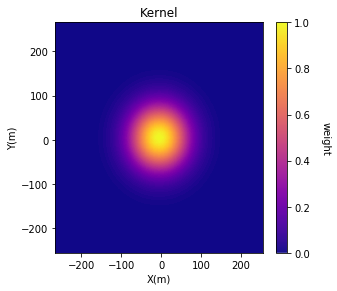

In [72]:
gkern1d = signal.gaussian(53,5).reshape(53, 1)
gkern2d = np.outer(gkern1d, gkern1d)
print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))

plt.subplot(111)
GSLIB.pixelplt_st(gkern2d,xmin=-265,xmax=265,ymin=-265,ymax=265,step=10,vmin=0,vmax=1,title='Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

In [73]:
import astropy.convolution.convolve as convolve
sand_trend = convolve(facies_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

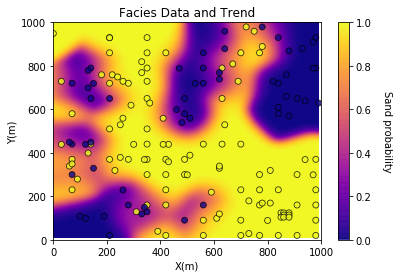

In [74]:
GSLIB.locpix_st(sand_trend,xmin,xmax,ymin,ymax,csize,0,1,df,'X','Y','Facies','Facies Data and Trend','X(m)','Y(m)','Sand probability',cmap)
plt.show()

In [75]:
facies_trend=np.zeros((np.shape(sand_trend)[0],np.shape(sand_trend)[1],2))
facies_trend[:,:,0] = 1-sand_trend; facies_trend[:,:,1] = sand_trend
facies_trend = correct_trend(facies_trend)

In [76]:
ikmap = ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,facies_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario=varios)

Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


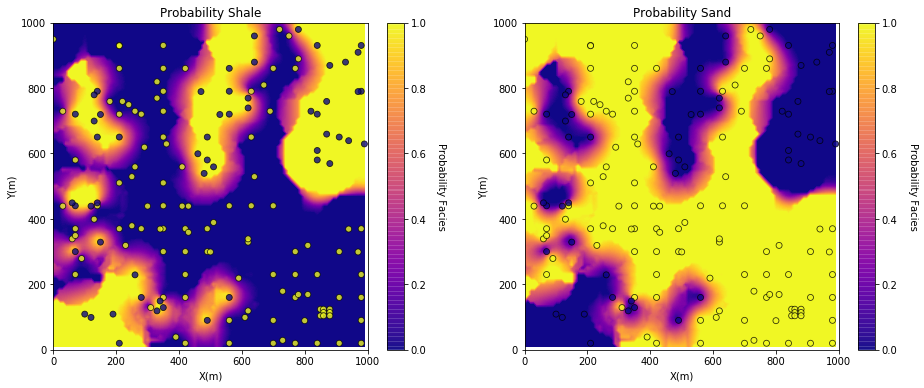

In [77]:
plt.subplot(221)
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)

plt.subplot(222)
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

# 3. Apply simple or ordinary kriging to calculate the kriging estimate and variance for porosity and permeability over the entire prospect, for each facies.

In [47]:
skmean_por_sand = 0.166; skmean_por_shale = 0.130
skmean_perm_sand = 110; skmean_perm_shale = 12
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value

In [43]:
por_sand_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200) # porosity shale variogram

perm_sand_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=70,hmaj1=400,hmin1=90,it2=1,cc2=0.3,azi2=70,hmaj2=750,hmin2=300) # perm sand variogram
perm_shale_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=70,hmaj1=400,hmin1=90,it2=1,cc2=0.3,azi2=70,hmaj2=750,hmin2=300) # perm shale variogram

facies_kmap = np.zeros((ny,nx)); por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

  Estimated   10000 blocks 
      average   0.15917507024744515  variance  0.000627530161076955
  Estimated   10000 blocks 
      average   71.45689361005846  variance  12495.300400424301
  Estimated   10000 blocks 
      average   0.13107143930716147  variance  0.0003173163058055595
  Estimated   10000 blocks 
      average   12.125953944291966  variance  410.36505176867695


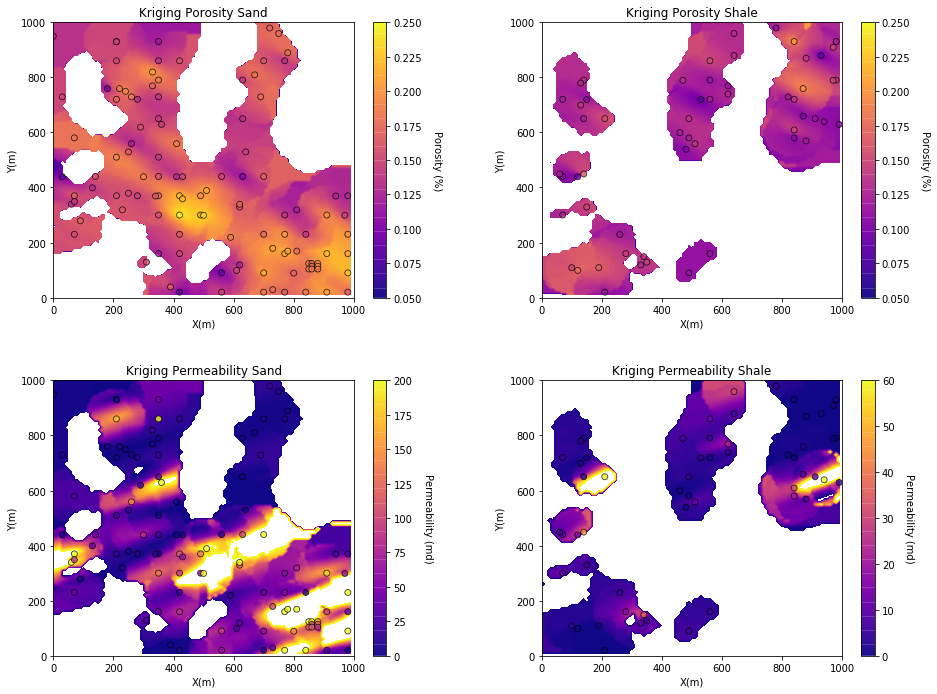

In [49]:
por_sand_kmap, por_sand_vmap = geostats.kb2d(df_sand,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_sand,por_sand_vario)

perm_sand_kmap, perm_sand_vmap = geostats.kb2d(df_sand,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm_sand,perm_sand_vario)

por_shale_kmap, por_shale_vmap = geostats.kb2d(df_shale,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_shale,por_shale_vario)

perm_shale_kmap, perm_shale_vmap = geostats.kb2d(df_shale,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm_shale,perm_shale_vario)

for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_kmap[iy,ix] = por_sand_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_sand_kmap[iy,ix];
            por_shale_kmap[iy,ix] = -1
            perm_shale_kmap[iy,ix] = -1
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_kmap[iy,ix] = por_shale_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_shale_kmap[iy,ix];
            por_sand_kmap[iy,ix] = -1
            perm_sand_kmap[iy,ix] = -1

plt.subplot(221)
GSLIB.locpix_st(por_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_sand,'X','Y','Porosity','Kriging Porosity Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.locpix_st(por_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df_shale,'X','Y','Porosity','Kriging Porosity Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,200,df_sand,'X','Y','Perm','Kriging Permeability Sand','X(m)','Y(m)','Permeability (md)',cmap)

plt.subplot(224)
GSLIB.locpix_st(perm_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,60,df_shale,'X','Y','Perm','Kriging Permeability Shale','X(m)','Y(m)','Permeability (md)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

# 4. Build a combined model (cookie cutter approach) with porosity and permeability for the most likely facies at all locations.

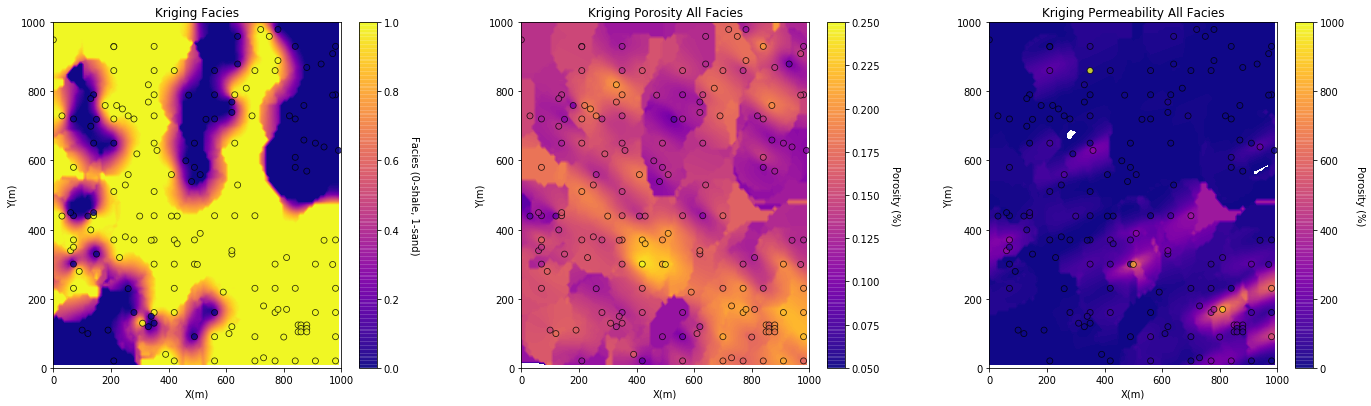

In [50]:
plt.subplot(131)
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0,1,df,'X','Y','Facies','Kriging Facies','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(132)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Kriging Porosity All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(133)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','Perm','Kriging Permeability All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

# 5. Report local P10 and P90 map.  For this, calculate the 10th and 90th percentile for porosity and permeability for the most likely facies at all locations.

In [155]:
por_threshold=np.percentile(df['Porosity'],[1,10,20,30,40,50,60,70,80,90,99])
perm_threshold=np.percentile(df['Perm'],[1,10,20,30,40,50,60,70,80,90,99])

In [161]:
xsiz = 10; ysiz = 10
nx = 100; ny = 100
xmn = 5; ymn = 5

ncut = 11                                   # number of thresholds
gcdf = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]                           # the global proportions of the categories
varios_por = []                                # the variogram list
for i in range(ncut):
    varios_por.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200)) # porosity indicator variogram
varios_perm = []                                # the variogram list
for i in range(ncut):
    varios_perm.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=70,hmaj1=400,hmin1=90,it2=1,cc2=0.3,azi2=70,hmaj2=750,hmin2=300)) # porosity indicator variogram

nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                                # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 1                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

no_trend = np.zeros((1,1))      

In [162]:
facies_kmap = np.zeros((ny,nx)); 
por_10_kmap = np.zeros((ny,nx));
por_90_kmap = np.zeros((ny,nx));
perm_10_kmap = np.zeros((ny,nx));
perm_90_kmap = np.zeros((ny,nx)) # declare array to combine values

In [163]:
ikmap_sand_por = ik2d(df_sand,'X','Y','Porosity',ivtype,0,ncut,por_threshold,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario=varios_por)
ikmap_sand_perm = ik2d(df_sand,'X','Y','Perm',ivtype,0,ncut,perm_threshold,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario=varios_perm)
ikmap_shale_por = ik2d(df_shale,'X','Y','Porosity',ivtype,0,ncut,por_threshold,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario=varios_por)
ikmap_shale_perm = ik2d(df_shale,'X','Y','Perm',ivtype,0,ncut,perm_threshold,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,
         ndmin,ndmax,radius,ktype,vario=varios_perm)

Data for IK3D: Variable column Porosity
  Number   = 112
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000
Data for IK3D: Variable column Perm
  Number   = 111
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000
Data for IK3D: Variable column Porosity
  Number   = 56
Setting up rotation matrices for variogram and search
Working on the kriging
   curren

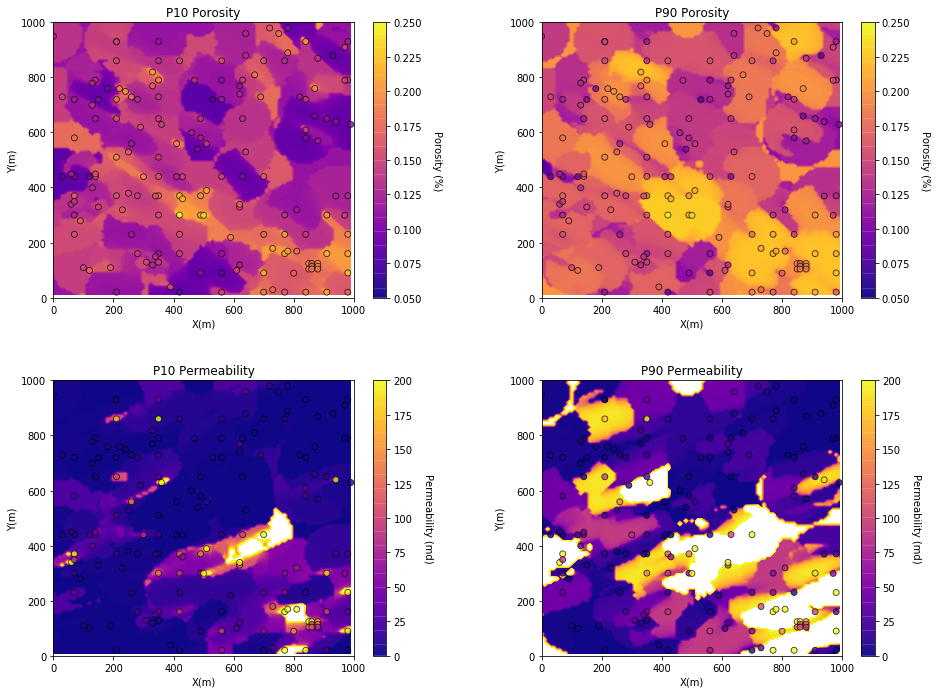

In [165]:
for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_10_kmap[iy,ix], por_90_kmap[iy,ix]= np.interp([0.1,0.9],ikmap_sand_por[iy,ix],por_threshold);
            perm_10_kmap[iy,ix], perm_90_kmap[iy,ix]= np.interp([0.1,0.9],ikmap_sand_perm[iy,ix],perm_threshold);
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_10_kmap[iy,ix], por_90_kmap[iy,ix]= np.interp([0.1,0.9],ikmap_shale_por[iy,ix],por_threshold);
            perm_10_kmap[iy,ix], perm_90_kmap[iy,ix]= np.interp([0.1,0.9],ikmap_shale_perm[iy,ix],perm_threshold);

por_10_kmap=np.clip(por_10_kmap, 0.01, 0.4)
por_90_kmap=np.clip(por_90_kmap, 0.01, 0.4)
perm_10_kmap=np.clip(perm_10_kmap, 0.01, 3000)
perm_90_kmap=np.clip(perm_90_kmap, 0.01, 3000)

plt.subplot(221)
GSLIB.locpix_st(por_10_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','P10 Porosity','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.locpix_st(por_90_kmap,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','P90 Porosity','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_10_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,200,df,'X','Y','Perm','P10 Permeability','X(m)','Y(m)','Permeability (md)',cmap)

plt.subplot(224)
GSLIB.locpix_st(perm_90_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,200,df,'X','Y','Perm','P90 Permeability','X(m)','Y(m)','Permeability (md)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

# 6. Pre-drill uncertainty distribution

The 2 proposed well locations are: (725,605) and (825,425). The corresponding indices in the kmap are (39,72) and (57,82). These two locations are chosen because they lie in an relatively undersampled area and drilling at these two locations can best help identify the boundary between the sand and shale facies.

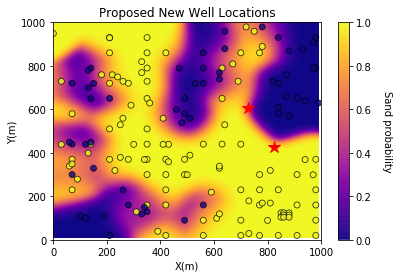

In [196]:
GSLIB.locpix_st(sand_trend,xmin,xmax,ymin,ymax,csize,0,1,df,'X','Y','Facies','Proposed New Well Locations','X(m)','Y(m)','Sand probability',cmap)
plt.plot(725,605,'r*', markersize=12)
plt.plot(825,425,'r*', markersize=12)
plt.show()

In [151]:
id1=[39,72]
id2=[57,82]

In [168]:
por_threshold

array([0.08374705, 0.11301329, 0.12361689, 0.13439615, 0.1422971 ,
       0.15011861, 0.16103212, 0.17232417, 0.18389721, 0.20028108,
       0.22797539])

In [169]:
dist1=ikmap_sand_por[id1[0],id1[1]]*ikmap[id1[0],id1[1],1]+ikmap_shale_por[id1[0],id1[1]]*ikmap[id1[0],id1[1],0]

In [171]:
dist2=ikmap_sand_por[id2[0],id2[1]]*ikmap[id2[0],id2[1],1]+ikmap_shale_por[id2[0],id2[1]]*ikmap[id2[0],id2[1],0]

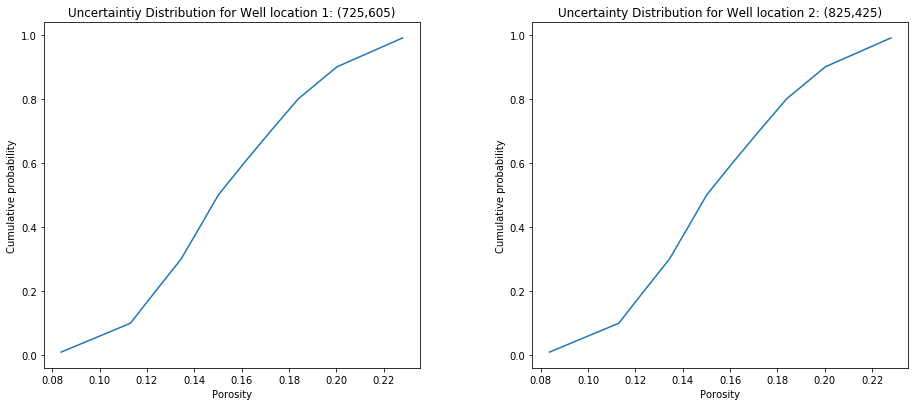

In [197]:
plt.subplot(121)
plt.plot(por_threshold,dist1)
plt.xlabel('Porosity')
plt.ylabel('Cumulative probability')
plt.title('Uncertaintiy Distribution for Well location 1: (725,605)')

plt.subplot(122)
plt.plot(por_threshold,dist2)
plt.xlabel('Porosity')
plt.ylabel('Cumulative probability')
plt.title('Uncertainty Distribution for Well location 2: (825,425)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

The CDF for the two proposed locations are identical to the global porosity distribution. This is expected because the kriging estimates at these two locations are global mean due to the large distance between proposed well locations and the rest of the data points. These means that currently no information can be derived at these two locations using spatial estimation. This result strengthens the argument that these locations need to be sampled to better identify facies boundary and provide more accurate reservoir characterization.